In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.nn import functional as F

In [161]:
class Edge:
    def __init__(self, src, dest, l, c, f):
        self.src = src
        self.dest = dest
        self.l, self.c, self.f = l, c, f

    def check_possibility(self, f):
        if self.l > f or self.c < f:
            return False
        return True

    def check_validity(self):
        if self.src == self.dest:
            return False
        # Bound Check
        if self.l > self.f or self.c < self.f:
            return False
        return True

    def update_excesses(self):
        self.src.excess -= self.f
        self.dest.excess += self.f

    def simple_data_representation(self):
        return [self.l, self.c, self.f, self.src.excess, self.dest.excess]

class Vertex:
    def __init__(self, name):
        self.name = name
        self.excess = 0

    def reset_excesses(self):
        self.excess = 0

class CircGraph:
    def __init__(self, vertices, edges):
        self.vertices = vertices
        self.n = len(vertices)
        self.edges = edges
        self.abs_excesses = 0

    def start_up(self, seed):
      ''' Generate random valid starting points'''
      np.random.seed(seed)
      for e in self.edges:
        e.f = np.random.uniform(e.l, e.c)
      self.calculate_excesses()

    def calculate_excesses(self):
        self.abs_excesses = 0
        for v in self.vertices:
            v.reset_excesses()
        for e in self.edges:
            e.update_excesses()
        for v in self.vertices:
            self.abs_excesses += abs(v.excess)

    def reward_function(self, adjustments):
        if self.modify_flows(adjustments):
            self.calculate_excesses()
            return self.abs_excesses / self.n
        else:
            return -1

    def c_reward_function(self, adjustments):
        self.c_modify_flows(adjustments)
        self.calculate_excesses()
        return self.abs_excesses / self.n

    def modify_flows(self, adjustments):
        '''Update the flow values in the graph's edges.

        Args:
            new_flows: List of new flow values for each edge

        Returns:
            Boolean indicating if all flow adjustments were valid
        '''
        for i, e in enumerate(self.edges):
            if i < len(adjustments):
                f_c = adjustments[i]
                if e.check_possibility(e.f + f_c):
                    e.f += f_c
                else:
                    return False
        return True

    def c_modify_flows(self, adjustments):
      for i, e in enumerate(self.edges):
            if i < len(adjustments):
                f_c = adjustments[i]
                if e.check_possibility(e.f + f_c):
                    e.f += f_c

    def return_data(self):
        data = []
        for e in self.edges:
            data = list(chain(data, e.simple_data_representation()))
        return data

In [55]:
vertices = [
    Vertex('s'),
    Vertex('a'),
    Vertex('b'),
    Vertex('t')
]

edges = [
      Edge(vertices[0], vertices[1], 3, 7, 3),
      Edge(vertices[0], vertices[2], 3, 4, 3),
      Edge(vertices[1], vertices[2], 2, 5, 2),
      Edge(vertices[1], vertices[3], 2, 3, 2),
      Edge(vertices[2], vertices[3], 3, 6, 5),
      Edge(vertices[3], vertices[0], 4, 4, 4),
]

In [56]:
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, num_heads, hidden_dim, num_layers):
        super(SimpleTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear1 = nn.Linear(seq_len * input_dim, output_dim * 2)
        self.linear2 = nn.Linear(seq_len * input_dim, output_dim)
        self.flatten = nn.Flatten(-2, -1)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.transformer_encoder(x)
        output = self.flatten(output) # (B, T * C)
        output = self.linear2(output) # (B, T, O)
        return output

In [62]:
seq_len = 6
input_dim = 5
output_dim = 3 ** seq_len
num_heads = 1
hidden_dim = 128
num_layers = 2
batch_size = 8
loss_fn = F.binary_cross_entropy_with_logits

In [58]:
sum(p.numel() for p in model.parameters())

70903

In [85]:
def get_input(graph):
    """
    Convert graph data into input format for the model.
    Returns a layered (seq_len, input_dim) representation of edge and vertex data.
    """
    return torch.tensor(graph.return_data(), dtype=torch.float32).view(1, -1, 5)

def to_bit(tensor, digits=6):
    """
    Convert a long tensor to a list of bits.
    """
    val = tensor.long().item()
    stra = np.base_repr(val, base=3).zfill(digits)[-digits:]
    bit_list = [int(bit) - 1 for bit in stra]
    return bit_list

In [106]:
def create_episodes(nb_steps, batch_size, model):
    """
    Generate episodes for training.

    Args:
        nb_steps: Number of steps per episode
        batch_size: Number of parallel environments
        model: The transformer model to use for action generation

    Returns:
        Histories of actions, inputs, and rewards
    """
    finito = False
    l_s = 0
    action_history = torch.zeros(nb_steps, batch_size, dtype = torch.int64)
    input_history = torch.zeros(nb_steps, batch_size, input_dim * seq_len)
    reward_history = torch.zeros(nb_steps, batch_size)

    graphs = [CircGraph(vertices, edges) for _ in range(batch_size)]
    for i, graph in enumerate(graphs):
        graph.start_up(seed=i)

    for step in range(nb_steps):
        for i, graph in enumerate(graphs):
            # If we did something illegal we will suffer until the end.
            if step != 0:
                if reward_history[step-1, i] == -1 or reward_history[step-1, i] == -69:
                    reward_history[step, i] = -69
                    break

            graph_data = get_input(graph)
            input_history[step, i] = graph_data.view(-1)[:input_dim * seq_len]

            with torch.no_grad():
                log_probs = model(graph_data.view(1, -1, 5))
                probs = F.softmax(log_probs, dim=1).view(-1)
                state = torch.multinomial(probs, num_samples=1, replacement=True).view(-1)
                predicted_adjustments = to_bit(state)
                action_history[step, i] = state
                reward = graph.reward_function(predicted_adjustments)
                reward_history[step, i] = reward
                # reward_history[step, i] = reward if reward != -1 else 0  # -1 means invalid action
                if reward == -1:
                    finito = True
        if finito:
            l_s = step
            break
    return action_history[:l_s+1], input_history[:l_s+1], reward_history[:l_s+1], l_s

def train_grpo(model, optimizer, num_epochs, batch_size=8, nb_steps=10):
    """
    Train the model using Group Reward Policy Optimization.

    Args:
        model: The transformer model
        optimizer: The optimizer to use
        num_epochs: Number of training epochs
        batch_size: Number of parallel environments
        nb_steps: Number of steps per episode
    """
    lossi = []
    for epoch in range(num_epochs):
        action_history, input_history, reward_history, l_s = create_episodes(nb_steps, batch_size, model)

        epsilon = 1e-7
        mean_rewards = reward_history.mean(dim=1, keepdim=True)
        std_rewards = reward_history.std(dim=1, keepdim=True) + epsilon
        normalized_rewards = (reward_history - mean_rewards) / std_rewards

        # Minus because we minimize
        f_rewards = normalized_rewards[-1, :]
        optimizer.zero_grad()
        total_loss = 0
        for t in range(l_s+1):
            step_inputs = input_history[t]
            log_probs = model(step_inputs.view(batch_size, seq_len, input_dim))
            # Indexing the actions taken in each edge in each graph sample, multiplying by final reward
            loss = -torch.mean(log_probs[:, action_history[t]] * f_rewards)
            total_loss += loss

        total_loss.backward()
        optimizer.step()
        lossi.append(total_loss.item())
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {lossi[-1]:.4f}')
    return model, lossi

In [107]:
num_epochs = 500
batch_size = 128
nb_steps = 10

model = SimpleTransformer(input_dim, output_dim, seq_len, num_heads, hidden_dim, num_layers)
# Initialize the optimizer
optimizer = optim.AdamW(model.parameters())

# Train the model using GRPO
model, lossi = train_grpo(model, optimizer, num_epochs, batch_size, nb_steps)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [100/500], Loss: -0.6350
Epoch [200/500], Loss: -0.8388
Epoch [300/500], Loss: 0.1275
Epoch [400/500], Loss: 0.1251
Epoch [500/500], Loss: -0.2034


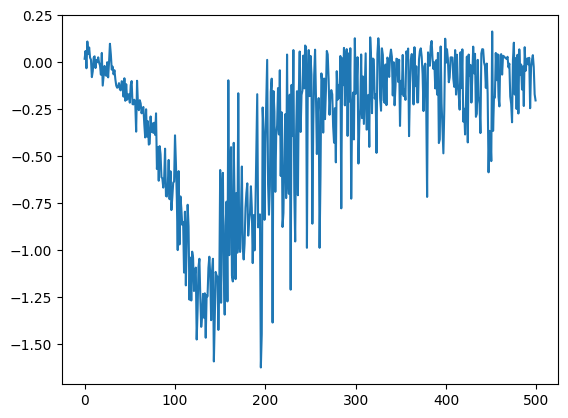

In [108]:
plt.plot(lossi)

In [162]:
graph = CircGraph(vertices, edges)
graph.start_up(seed=np.random.randint(100))

reward = 0
cnt = 0
while reward != -1 and cnt < 100:
    print(reward)
    log_probs = model(get_input(graph))
    probs = F.softmax(log_probs, dim=1).view(-1)
    state = torch.multinomial(probs, num_samples=1, replacement=True).view(-1)
    predicted_adjustments = to_bit(state)
    reward = graph.c_reward_function(predicted_adjustments)

print(reward)

0
2.287083356997657
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.787083356997657
2.787083356997657
2.3517620069642575
2.787083356997657
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.787083356997657
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.787083356997657
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.3517620069642575
2.787083356997657
2.787083356997657
2.3517620069642575

KeyboardInterrupt: 